<a href="https://colab.research.google.com/github/medha-sagar/CSE547-BigDataForMachineLearning/blob/master/CSE547_HW2_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE547 - PCA

Adapted from Stanford's CS246

# Setup

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u242-b08-0ubuntu3~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1Ri_u6ekK_JSGAjFRk2LIBNnM4rG2MDzm'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('faces.csv')




Next, we import some of the common libraries needed for our task.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [0]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [9]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-04-29 02:18:55--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.2.164.113, 34.196.211.120, 52.73.195.55, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.2.164.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  19.0MB/s    in 0.7s    

2020-04-29 02:18:56 (19.0 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://df74e999.ngrok.io


# Data Loading

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
faces = spark.read.option("sep", ",").csv("faces.csv", header=False)
faces_df = pd.read_csv("faces.csv", header = None)

In [0]:
n,d = faces_df.shape

# Getting Eigen Values and Eigen Vectors

In [0]:
sigma = np.dot(np.transpose(faces_df), faces_df)/n

In [0]:
eig_val, eig_vec = np.linalg.eig(sigma)

In [0]:
# Sorting Eigen values and vectors
order = eig_val.argsort()[::-1]
eig_values = eig_val[order]
eig_vectors = eig_vec[:,order]

In [78]:
vals = [0, 1, 9, 29, 49]
for val in vals:
  print("Eigenvalue for {} component is {}".format(val+1, eig_val[val].real))
print("Sum of eigenvalues is {}".format(np.sum(eig_values.real)))

Eigenvalue for 1 component is 781.8126992600016
Eigenvalue for 2 component is 161.15157496732687
Eigenvalue for 10 component is 3.3395867548878173
Eigenvalue for 30 component is 0.809087790377722
Eigenvalue for 50 component is 0.38957773951814395
Sum of eigenvalues is 1084.2074349947675


# Getting Fractional Error

In [0]:
# Calculating fractional error
temp = []
frac_error = []
for i in eig_values[0:51]:
    temp.append(i.real)
    frac_error.append(1 - (np.sum(temp)/np.sum(eig_values.real)))


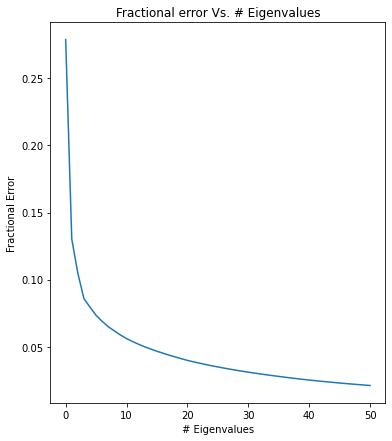

In [27]:
plt.figure(figsize=(6,7))
plt.plot(frac_error)
plt.title("Fractional error Vs. # Eigenvalues")
plt.xlabel("# Eigenvalues")
plt.ylabel("Fractional Error")
plt.savefig('frac_error.png', dpi = 300)
plt.show()

# Eigen Faces Using Eigen Vectors

In [0]:
def get_k_eigenfaces(eig_values, eig_vectors, k_comp):
	k_comp_eig_val = eig_values.argsort()[-k_comp:][::-1]
	eigen_faces = []
	for i in k_comp_eig_val:
		eigen_faces.append(eig_vectors[:, i].real)
	return np.array(eigen_faces)

In [0]:
def get_actual_eigenfaces(eigen_faces):
	temp = []
	for i in range(eigen_faces.shape[0]):
		temp.append(eigen_faces[i].reshape(84, 96).T)
	return np.array(temp)

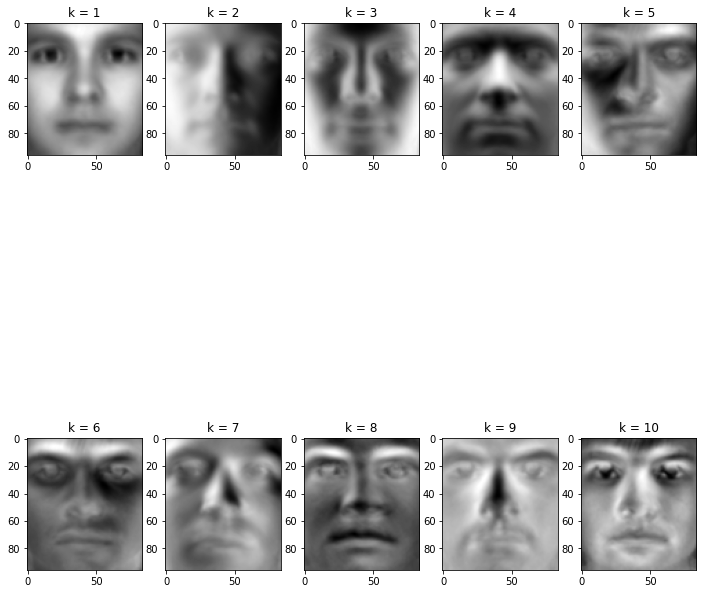

In [73]:
eigen_faces = get_k_eigenfaces(eig_values, eig_vectors, 10)
eigfaces = get_actual_eigenfaces(eigen_faces)

w=50
h=50
fig=plt.figure(figsize=(12, 14))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(eigfaces[i-1], cmap='gray')
    plt.title('k = '+str(i))
plt.savefig('eigenfaces.png')
plt.show()

# Reconstruction of Original Images

In [0]:
eigen_faces = get_k_eigenfaces(eig_values, eig_vectors, n)
img_locs = [0, 23, 64 ,67, 256]
components=[1,2,5,10,50]
reconc_images = []
for img_loc in img_locs:
  reconc_images.append(np.array(faces_df.iloc[img_loc]))

  for j in components:
    e_f = np.dot(faces_df.iloc[img_loc], eigen_faces[:j].T)
    reconstructed_img = np.dot(e_f, eigen_faces[:j])
    reconc_images.append(reconstructed_img)


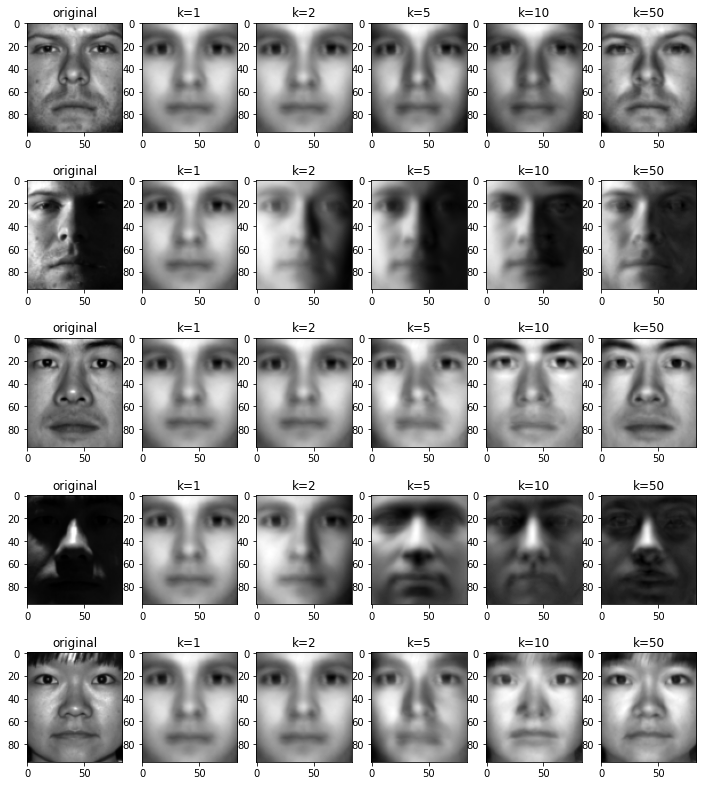

In [86]:
w=50
h=50
columns = 6
rows = 5
fig=plt.figure(figsize=(12, 14))
for i in range(1, columns*rows +1):
    labels = ['original', 'k=1', 'k=2','k=5', 'k=10','k=50'] * 5
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(reconc_images[i-1].reshape((84, 96)).T, cmap='gray')
    plt.title(labels[i-1])
plt.savefig('recon.png')
plt.show()